In [1]:
import pandas as pd
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
df = pd.read_csv('2020-04-29 Coronavirus Tweets.CSV')

Let's look at the top five rows of our dataset to get a basic overview

In [162]:
df.head()

,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,followers_count,friends_count,account_created_at,verified,lang,language
0,2020-04-29T00:00:00Z,Las solicitudes de hospitales y otras organiza...,TweetDeck,False,False,13,0,3,25,2020-03-30T04:56:21Z,False,es,Spanish
1,2020-04-29T00:00:00Z,Prepara tu propio gel antibacterial es fácil ...,TweetDeck,False,False,1828,0,1710,169,2017-01-05T18:17:00Z,False,es,Spanish
2,2020-04-29T00:00:00Z,"Por más terror que cause, la apocalíptica rela...",TweetDeck,False,False,836,0,122908,4370,2010-08-30T15:47:01Z,False,es,Spanish
3,2020-04-29T00:00:00Z,Panorama en #Tabasco de casos de #COVID19 #Ent...,TweetDeck,False,False,6317,3,145940,3116,2009-10-15T12:46:02Z,False,es,Spanish
4,2020-04-29T00:00:00Z,#Francia comenzará a levantar las medidas de c...,TweetDeck,False,False,5801,1,13548,2553,2018-09-19T19:40:04Z,False,es,Spanish


The first two columns and also the 'screen_name' column can be dropped as they wont be necessary during Visualization

In [4]:
df.drop(['status_id', 'user_id', 'screen_name'], axis = 1, inplace = True)

Before starting first let's check the amount of missing values present

In [5]:
num_tweets = len(df)

In [6]:
df.isnull().sum()/num_tweets * 100

created_at                0.000000
text                      0.000000
source                    0.000767
reply_to_status_id       88.487157
reply_to_user_id         85.870323
reply_to_screen_name     85.870323
is_quote                  0.000000
is_retweet                0.000000
favourites_count          0.000000
retweet_count             0.000000
country_code             95.943167
place_full_name          95.931669
place_type               95.931669
followers_count           0.000000
friends_count             0.000000
account_lang            100.000000
account_created_at        0.000000
verified                  0.000000
lang                      0.000000
dtype: float64

There are 7 columns with more than 85% of it's values missing so I will be dropping these as they won't provide much info

In [7]:
missing_cols = list(df.columns[(df.isnull().sum()/num_tweets * 100) > 85.0])

df.drop(missing_cols, axis = 1, inplace = True)

Adding a 'Language' column using the given language codes

In [8]:
from iso639 import languages

def get_language(x):
    try:
        return languages.get(alpha2=x).name 
    except KeyError:
        return x

In [9]:
df['language'] = df['lang'].apply(lambda x: get_language(x))

In [10]:
df['language'].value_counts()[:10]

English       220923
Spanish        60837
French         23133
und            16933
Italian        12634
Portuguese     10079
German          6613
Hindi           5447
in              4206
Catalan         3781
Name: language, dtype: int64

In [11]:
df['language'] = df['language'].str.replace('und','Undefined')

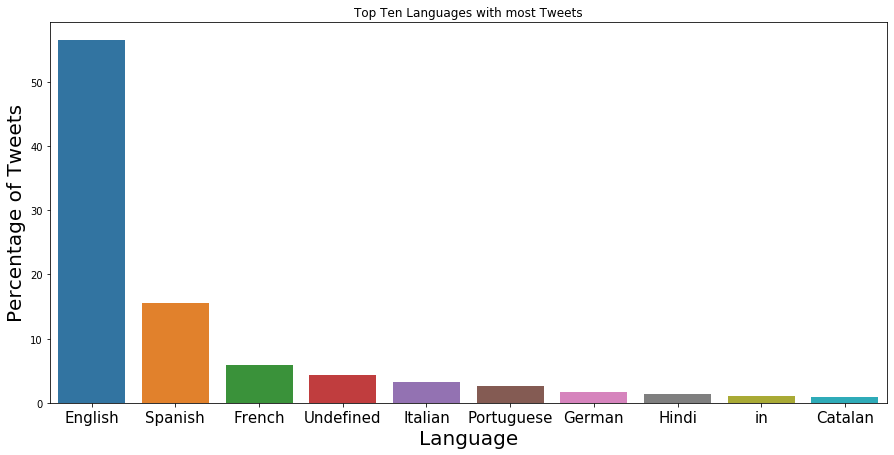

In [12]:
plt.figure(figsize = (15,7))
sns.barplot(x = df['language'].value_counts()[:10].index , y = df['language'].value_counts()[:10]/num_tweets*100)
plt.xlabel('Language', fontsize = 20)
plt.ylabel('Percentage of Tweets', fontsize = 20)
plt.xticks(fontsize = 15)
plt.title('Top Ten Languages with most Tweets')
plt.show()

We see that 56% of all tweets are in English which is no surprise followed by Spanish and French at 15% and 5% respectively.

# Sentiment Classification

Before I can continue with any visualization I have to first Classify the sentiment of each tweet

For now I'll be only focusing on the English tweets

In [122]:
df_eng = df[df['language'] == 'English']

In [123]:
df_eng['language'].value_counts()

English    220923
Name: language, dtype: int64

Let's take a look at one of the tweets

In [124]:
df_eng['text'][1128]

"#Coronavirus #Facebook Seriously Facebook?  This is Ridiculous!\nArmy chaplains' prayer videos during coronavirus removed from Facebook after complaints\n\nhttps://t.co/JabCnPSrsF"

As you can see the tweets are not clean, so i've made a function to clean and tokenize them which will be in my repo linked at the bottom

In [125]:
from clean_text import CleanText 
clean = CleanText()

In [126]:
#df_eng['text_clean'] = df_eng['text'].apply(lambda x: clean.clean(x)) #Insert the clean text in a new column

In [127]:
#df_eng.to_pickle('tweets_eng.pkl')

In [4]:
df_eng = pd.read_pickle('tweets_eng.pkl')

In [5]:
df_eng['text_clean'][1128]

['coronavirus',
 'facebook',
 'seriously',
 'facebook',
 'ridiculous',
 'army',
 'chaplain',
 'prayer',
 'video',
 'coronavirus',
 'removed',
 'facebook',
 'complaint',
 'http',
 '//t.co/jabcnpsrsf']

The function has managed to remove all of the unnecessary punctuations and stop words but most of these tweets have an url at the end. They have to be removed.

In [6]:
def remove_url(x):
    if len(x) <= 2 :
        pass
    elif x[-1] == 'http':
        x.pop(-1)        
    elif x[-2] == 'http':
        del x[-2:]  
    return x    

In [7]:
df_eng['text_clean'] = df_eng['text_clean'].apply(lambda x: remove_url(x))

In [8]:
df_eng['text_clean'][1128]

['coronavirus',
 'facebook',
 'seriously',
 'facebook',
 'ridiculous',
 'army',
 'chaplain',
 'prayer',
 'video',
 'coronavirus',
 'removed',
 'facebook',
 'complaint']

All the urls have been removed from the data

### Word Embeddings

Before we can start with the classification we have to find a way to represent the words.
Now there two popular ways to do this: <b> Word Vectors</b> and <b>Word Embeddings</b>

<b>Word Vectors</b> are high dimensional sparse (mostly 0s) vectors where each vector represents a word which is simply one hot encoded.
<b>Word Embeddings</b> unlike word vectors represent the words in dense vectors. The words are mapped into a meaningful space where the distance between words is related to their semantic similarity.


I'll be using pretrained <b>GloVe</b> embeddings to represent the words

In [9]:
docs = df_eng['text_clean']

#tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

#encode the documents
encoded_docs = t.texts_to_sequences(docs)

#pad docs to max length
padded_docs = pad_sequences(encoded_docs, maxlen = 22, padding = 'post') 

As this this an <b>Unsupervised</b> problem (i.e the sentiments for the tweets have not been provided) the classifier can be trained on any public data which contains labels. So I trained my model on an airline tweets sentiment dataset(availble in kaggle) in which the tweets were separated into three sentiments <b>'Positive', 'Negative'</b> and <b>'Neutral'</b>

This dataset was trained on a 6 layer <b>LSTM</b> network with pretained <b>GloVe embeddings</b>. The model is available in my repository as 'sentiment_classifier.py'. The final model which I've used below had an accuracy of:<b> Train set 87%, Dev set 81%, Test set 80%</b>

In [164]:
# Loading the classifier 
classifier = keras.models.load_model('Models/sentiment_classifier4.h5') #Negative: 0, Neutral: 1, Postive: 2

In [167]:
labels_categorical = classifier.predict(padded_docs) # Predicting the Sentiments of the Covid-19 tweets

In [169]:
labels_categorical[:10] #Output of each class by the softmax function

array([[9.3989122e-01, 5.2788042e-02, 7.3206751e-03],
       [1.0381279e-01, 8.3070862e-01, 6.5478496e-02],
       [9.6528947e-01, 3.0899795e-02, 3.8106751e-03],
       [9.9593252e-01, 3.7601998e-03, 3.0725889e-04],
       [9.9636286e-01, 3.3681840e-03, 2.6893226e-04],
       [2.8948715e-01, 6.5156311e-01, 5.8949798e-02],
       [7.6280487e-01, 2.0351055e-01, 3.3684608e-02],
       [9.8935646e-01, 3.8825278e-03, 6.7610433e-03],
       [6.9110371e-02, 1.4166999e-01, 7.8921968e-01],
       [9.9513584e-01, 4.4084364e-03, 4.5583124e-04]], dtype=float32)

In [173]:
np.argmax(labels_categorical[:10], axis = 1) #np.argmax to get labels of the classes Negative: 0, Neutral: 1, Postive: 2

array([0, 1, 0, 0, 0, 1, 0, 0, 2, 0], dtype=int64)

In [175]:
df_eng['labels'] = np.argmax(labels_categorical, axis = 1)

In [1]:
df_eng.head()

NameError: name 'df_eng' is not defined

In [178]:
#Saving the dataframe as a pickle file to resume where I left off incase the kernel crashes or if I have to continue some other day

df_eng.to_pickle('final_df.pkl') #Also reading and writing pickle files are much faster than csv

In [2]:
df_eng = pd.read_pickle('final_df.pkl')

In [3]:
def label_to_sentiment(label):
    if label == 0:
        return 'Negative'
    elif label == 1:
        return 'Neutral'
    else:
        return 'Positive'

In [4]:
df_eng['sentiment'] = df_eng['labels'].apply(lambda x: label_to_sentiment(x))

In [5]:
pd.set_option('max_colwidth', 200)
df_eng[['text','sentiment']].iloc[368:373] #Let's check some random tweets to see if the predicted sentiments make sense

,text,sentiment
609,#Coronavirus bill,Neutral
610,"Qld Premier fakes getting the flu shot!\n\nIn the video beliow on 7News, the Qld Premier was being filmed ""getting"" the flu shot, but its fake! Didn't remove the cap or press the plunger... \n\nWa...",Negative
611,"Help slow the spread of #COVID19 and identify at risk cases sooner by self-reporting your symptoms daily, even if you feel well 🙏. Download the app https://t.co/Rp9dvQjMgL",Positive
612,"National @EmersonPolling, On How Voters See Trump Handling The #COVID19:\n\nApprove 39% (-10)\nDisapprove 51% (+10)",Neutral
614,"LIVE UPDATES: VP Pence visits coronavirus patients without wearing a mask, United States reaches 1 million confirmed cases https://t.co/WGVycF1fS9 by - Reformed Control Freak Daily News @briansmit...",Negative


We can see that the classifier has managed to classify the sentiments quite well.

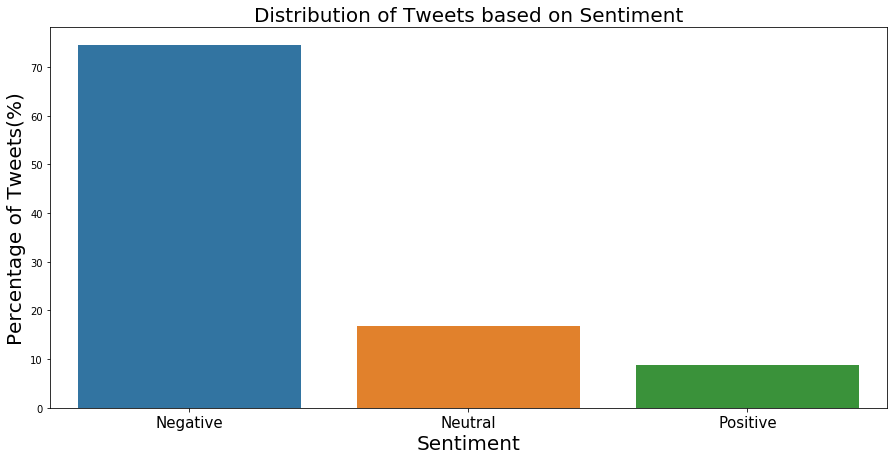

In [74]:
plt.figure(figsize = (15,7))
sns.barplot(x = df_eng['sentiment'].value_counts().index, y = df_eng['sentiment'].value_counts()/len(df_eng)*100)
plt.xlabel('Sentiment', fontsize = 20)
plt.ylabel('Percentage of Tweets(%)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.title('Distribution of Tweets based on Sentiment', fontsize = 20)
plt.show()

In [76]:
from wordcloud import WordCloud
def plot_wordcloud(data):
    words = []
    for sent in data:
        for word in sent:
            words.append(word)
    print(words)  
    words = pd.Series(words).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(words)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



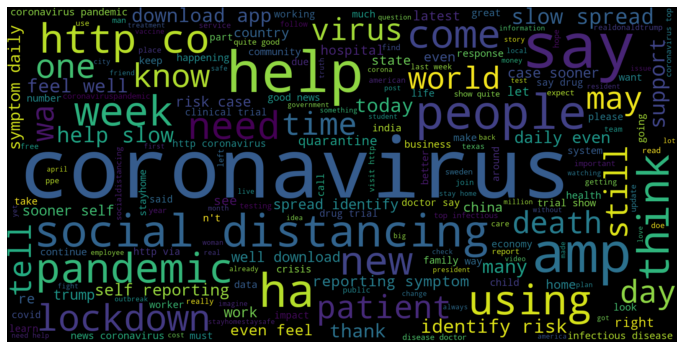

In [75]:
plot_wordcloud(df_eng['text_clean'][df_eng['sentiment'] == 'Positive'])

There some words which are common in both the positive and negative tweets like Coronavirus, Pandemic, Lockdown because they are the main subject of these tweets and are therefore used in most of these tweets.

<b>Positive tweets:</b> These mostly contain words like 'help', 'social distancing',  'self reporting' which are related to spreading awareness about how the spread of virus can be slowed down by staying at home and containing the pandemic. Also people have shared different ways through which one can take care of their mental health like self reporting.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



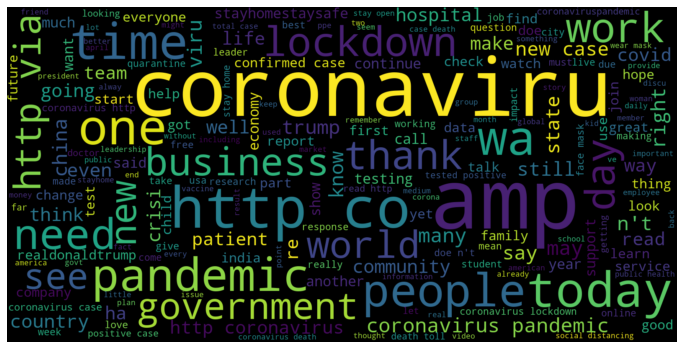

In [77]:
plot_wordcloud(df_eng['text_clean'][df_eng['sentiment'] == 'Negative'])

<b>Negative tweets:</b> These tweets mostly contain words like 'business', 'work', 'government' which are related to how businesses are facing heavy losses during this lockdown and how this has caused many employees to be laid off as their companies are not able to make enough profits.

# Hashtags Visualization

In [6]:
import nltk

In [7]:
import re
def extract_hashtag(text):
    hashtags=[]
    for i in text:
        ht=re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

In [8]:
all_hashtags=extract_hashtag(df_eng.text)
def df_hashtag(sentiment_label):
    hashtags=extract_hashtag(df_eng.text[df_eng['sentiment']==sentiment_label])
    ht_fredist=nltk.FreqDist(sum(hashtags,[]))
    df_ht=pd.DataFrame({'Hashtag':list(ht_fredist.keys()),'Count':list(ht_fredist.values())})
    return df_ht

In [9]:
#Hashtags dataframes
# ht_neg_df=df_hashtag('Negative')
# ht_neu_df=df_hashtag('Neutral')
# ht_pos_df=df_hashtag('Positive')

In [10]:
ht_neg_df.to_pickle('ht_neg_df.pkl')
ht_neu_df.to_pickle('ht_neu_df.pkl')
ht_pos_df.to_pickle('ht_pos_df.pkl')

In [24]:
def plot_hashtag(df,title):
    data=df.nlargest(columns="Count",n=20)
    plt.figure(figsize=(16,5))
    ax=sns.barplot(data=data,x='Hashtag',y='Count')
    plt.suptitle(title, fontsize=20)
    plt.xlabel('Hashtag', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.xticks(rotation=90)
    plt.tick_params(labelsize=15)
    plt.show()

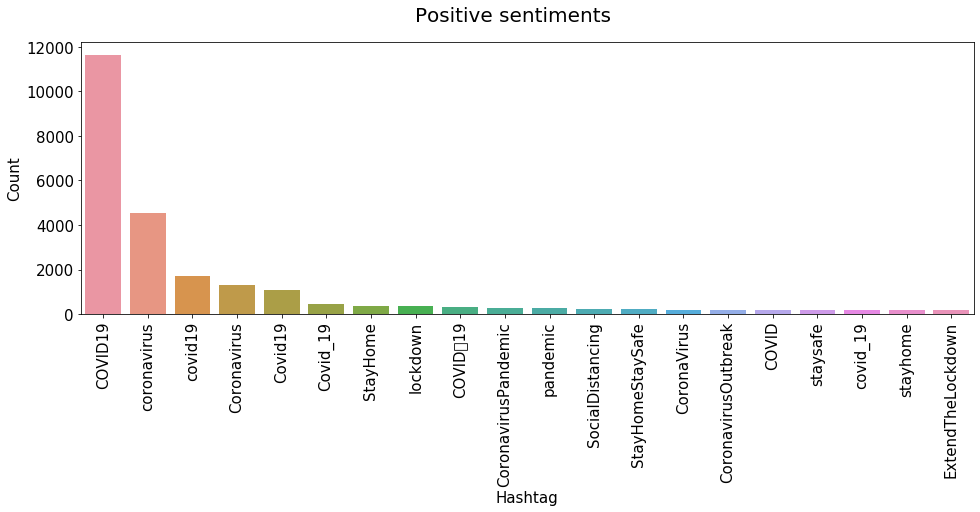

In [25]:
plot_hashtag(ht_pos_df,'Positive sentiments')

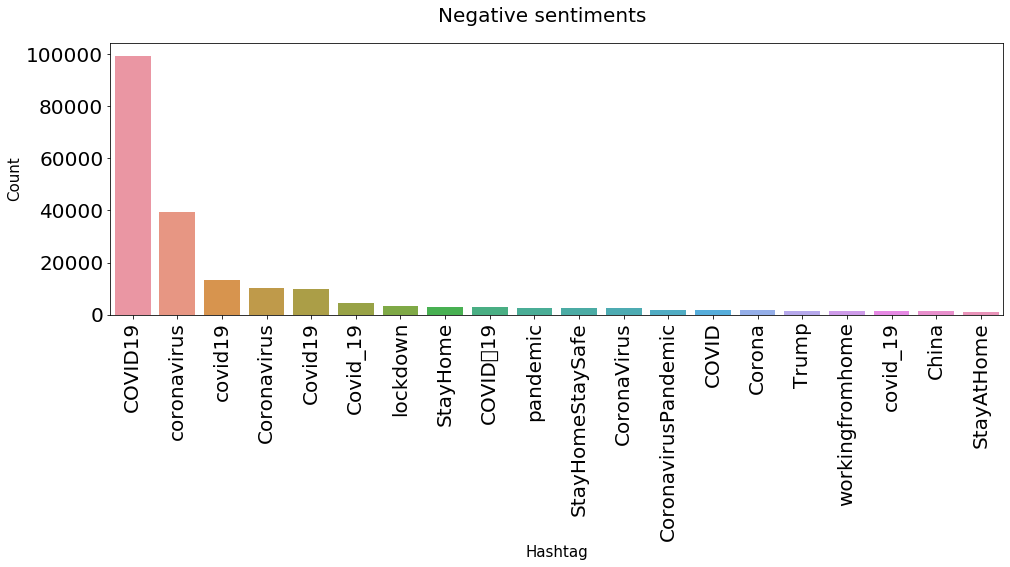

In [23]:
plot_hashtag(ht_neg_df,'Negative sentiments')

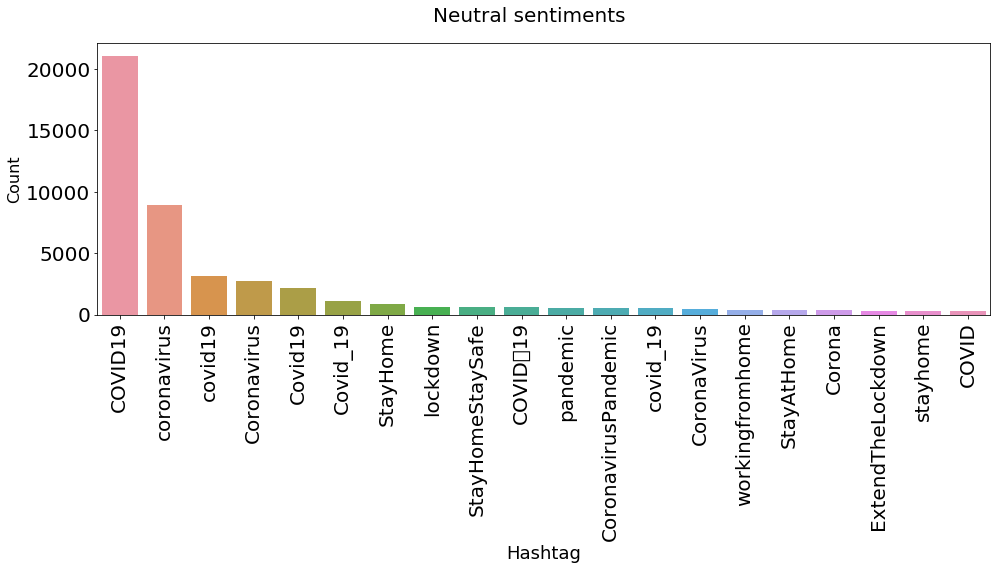

In [14]:
plot_hashtag(ht_neu_df,'Neutral sentiments')

## Top 3 Most Liked Tweets

In [33]:
df_eng.sort_values(by = 'favourites_count', ascending = False).iloc[:3][['text','favourites_count']]

,text,favourites_count
32679,It's time @SmithfieldFoods took responsibility for what they did &amp; how they didn't protect their workers when the first case of #COVID19 came out in their factory like so not right at all!!! 😡...,1995152
210944,"Terrible, may she RIP. Hopefully this doesn't become a trend and medical professionals get the mental healthcare they need to overcome so much suffering and death.\n#Coronavirus: Top NYC doctor ta...",1311806
283689,"In 2019, Trump admin restarted&amp;funded controversial Wuhan lab with millions of U.S. dollars for risky #coronavirus ""gain of function"" research, which tested how bat🦇 coronavirus could mutate t...",1311600


## Top 3 Most Retweeted Tweets

In [36]:
df_eng.sort_values(by = 'retweet_count', ascending = False).iloc[:3][['text','retweet_count']]

,text,retweet_count
284406,"I again want to thank @realDonaldTrump and @VP for supporting the people of Louisiana during this difficult time. We had a great conversation today, and I look forward to continuing to work with o...",6011
275987,"BREAKING: America's top #coronavirus scientific adviser says a US trial of 1,000+ volunteers shows a drug CAN block this virus.. &amp; it's a clear cut..positive result in diminishing the time to ...",5336
210304,"AG Barr will be participating in the nationwide #AskTheAG Q&amp;A session on May 1 at 12pm ET\n \nSend us your Qs on how DOJ is protecting public safety &amp; combatting fraud, price gouging, hoar...",5302
